<a href="https://colab.research.google.com/github/akash-jogi-835/Internship_Assesment/blob/main/Neural_Language_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision torchaudio


In [2]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [4]:
import random
import numpy as np
import torch

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


# **Load Dataset from Google Drive**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os

DATASET_PATH = "/content/drive/MyDrive/dataset/Pride_and_Prejudice-Jane_Austen.txt"

print("Dataset file exists:", os.path.exists(DATASET_PATH))

Dataset file exists: True


In [9]:
with open(DATASET_PATH, "r", encoding="utf-8") as f:
    raw_text = f.read()

print("Total characters:", len(raw_text))
print("Sample text:\n", raw_text[:500])

Total characters: 711331
Sample text:
 The Project Gutenberg eBook, Pride and Prejudice, by Jane Austen, Edited
by R. W. (Robert William) Chapman


This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included
with this eBook or online at www.gutenberg.org





Title: Pride and Prejudice


Author: Jane Austen

Editor: R. W. (Robert William) Chapman

Release Date: May 9, 2013  [eBook #42671]

Lang


# **Basic Text Cleaning**

In [10]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s.,!?;:']", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

cleaned_text = clean_text(raw_text)

print("Before cleaning:", raw_text[:200])
print("\nAfter cleaning:", cleaned_text[:200])

Before cleaning: The Project Gutenberg eBook, Pride and Prejudice, by Jane Austen, Edited
by R. W. (Robert William) Chapman


This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions wha

After cleaning: the project gutenberg ebook, pride and prejudice, by jane austen, edited by r. w. robert william chapman this ebook is for the use of anyone anywhere at no cost and with almost no restrictions whatsoe


In [11]:
tokens = cleaned_text.split()

print("Total tokens:", len(tokens))
print("Sample tokens:", tokens[:20])

Total tokens: 126008
Sample tokens: ['the', 'project', 'gutenberg', 'ebook,', 'pride', 'and', 'prejudice,', 'by', 'jane', 'austen,', 'edited', 'by', 'r.', 'w.', 'robert', 'william', 'chapman', 'this', 'ebook', 'is']


In [12]:
from collections import Counter

word_freq = Counter(tokens)

vocab = sorted(word_freq.keys())
vocab_size = len(vocab)

print("Vocabulary size:", vocab_size)

Vocabulary size: 11571


In [13]:
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}

print("Sample mapping:")
for i in range(5):
    print(vocab[i], "->", word2idx[vocab[i]])

Sample mapping:
' -> 0
'ah! -> 1
'as -> 2
'bingley, -> 3
'had -> 4


In [14]:
token_ids = [word2idx[word] for word in tokens]

print("Token IDs sample:", token_ids[:20])


Token IDs sample: [10271, 8133, 4775, 3373, 8052, 585, 7975, 1460, 5798, 964, 3389, 1460, 8327, 11066, 8934, 11306, 1649, 10343, 3372, 5772]


# **Data Preparation**

In [15]:
SEQ_LENGTH = 30  # can tune later

def create_sequences(token_ids, seq_length):
    inputs = []
    targets = []

    for i in range(len(token_ids) - seq_length):
        inputs.append(token_ids[i:i + seq_length])
        targets.append(token_ids[i + seq_length])

    return inputs, targets

inputs, targets = create_sequences(token_ids, SEQ_LENGTH)

print("Total sequences:", len(inputs))
print("Sample input:", inputs[0])
print("Sample target:", targets[0])

Total sequences: 125978
Sample input: [10271, 8133, 4775, 3373, 8052, 585, 7975, 1460, 5798, 964, 3389, 1460, 8327, 11066, 8934, 11306, 1649, 10343, 3372, 5772, 4268, 10271, 10887, 7184, 656, 660, 883, 7001, 2370, 585]
Sample target: 11359


In [16]:
split_ratio = 0.9
split_idx = int(len(inputs) * split_ratio)

train_inputs = inputs[:split_idx]
train_targets = targets[:split_idx]

val_inputs = inputs[split_idx:]
val_targets = targets[split_idx:]

print("Train samples:", len(train_inputs))
print("Validation samples:", len(val_inputs))

Train samples: 113380
Validation samples: 12598


In [17]:
from torch.utils.data import Dataset

class LanguageModelDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.inputs[idx], dtype=torch.long),
            torch.tensor(self.targets[idx], dtype=torch.long)
        )


In [18]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64  # adjustable later

train_dataset = LanguageModelDataset(train_inputs, train_targets)
val_dataset = LanguageModelDataset(val_inputs, val_targets)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [19]:
for x, y in train_loader:
    print("Input batch shape:", x.shape)   # (batch_size, seq_length)
    print("Target batch shape:", y.shape)  # (batch_size,)
    break


Input batch shape: torch.Size([64, 30])
Target batch shape: torch.Size([64])


# **Model Implementation**

**LSTM Language Model**

In [44]:
import torch.nn as nn

class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout=0.5):
        super(LSTMLanguageModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_size)

        # LSTM Layer
        self.lstm = nn.LSTM(
            input_size=embed_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

        # 1. ADDED: Explicit Dropout Layer for the final output
        self.dropout_layer = nn.Dropout(dropout)

        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, _ = self.lstm(embeds)

        # Take only the last time step
        last_hidden = lstm_out[:, -1, :]

        # 2. ADDED: Apply dropout here
        last_hidden = self.dropout_layer(last_hidden)

        logits = self.fc(last_hidden)
        return logits


In [45]:
VOCAB_SIZE = vocab_size
EMBED_SIZE = 128
HIDDEN_SIZE = 256
NUM_LAYERS = 2
DROPOUT = 0.2

model = LSTMLanguageModel(
    vocab_size=VOCAB_SIZE,
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(device)

print(model)


LSTMLanguageModel(
  (embedding): Embedding(11571, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.2)
  (dropout_layer): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=11571, bias=True)
)


In [46]:
sample_x, _ = next(iter(train_loader))
sample_x = sample_x.to(device)

with torch.no_grad():
    sample_output = model(sample_x)

print("Output shape:", sample_output.shape)


Output shape: torch.Size([64, 11571])


# **Training Pipeline**

In [47]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [48]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        # 3. ADDED: Gradient Clipping
        # This prevents the "exploding gradient" problem common in LSTMs
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)

In [49]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss.item()

    return total_loss / len(dataloader)


In [50]:
EPOCHS = 5  # will adjust later for experiments

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch [1/5] Train Loss: 6.6137 | Val Loss: 6.7632
Epoch [2/5] Train Loss: 5.9457 | Val Loss: 6.6253
Epoch [3/5] Train Loss: 5.5811 | Val Loss: 6.5847
Epoch [4/5] Train Loss: 5.2768 | Val Loss: 6.6621
Epoch [5/5] Train Loss: 4.9971 | Val Loss: 6.7844


In [51]:
import math

def perplexity(loss):
    return math.exp(loss)

val_ppl = perplexity(val_losses[-1])
print("Validation Perplexity:", val_ppl)


Validation Perplexity: 883.9671421233126


# **MANDATORY EXPERIMENTS**

In [55]:
def run_experiment(model, train_loader, val_loader, epochs, lr=0.001):
    criterion = nn.CrossEntropyLoss()

    # Add Weight Decay (L2 Regularization) to the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    # 4. ADDED: Scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=1
    )

    train_losses, val_losses = [], []

    # Early Stopping setup
    best_val_loss = float('inf')
    patience_counter = 0
    early_stopping_limit = 3  # Stop if no improvement for 3 epochs

    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss = evaluate(model, val_loader, criterion, device)

        # Step the scheduler
        scheduler.step(val_loss)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        # 5. ADDED: Simple Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model here if you want
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_limit:
                print("Early stopping triggered!")
                break

    return train_losses, val_losses

# **UNDERFITTING**

In [56]:
# Refined Model: Increased capacity to capture complex patterns
good_fit_model = LSTMLanguageModel( # Use the rectified class we defined earlier
    vocab_size=vocab_size,
    embed_size=128,      # CHANGED: Increased from 32 to 128
    hidden_size=256,     # CHANGED: Increased from 64 to 256
    num_layers=2,        # CHANGED: Increased from 1 to 2 for deeper learning
    dropout=0.5          # CHANGED: Added dropout to manage the new capacity
).to(device)

In [57]:
# Refined Experiment: Give the model time to learn
good_fit_train_losses, good_fit_val_losses = run_experiment(
    good_fit_model,
    train_loader,
    val_loader,
    epochs=15            # CHANGED: Increased from 3 to 15
)

Epoch 1 | Train Loss: 6.5980 | Val Loss: 6.5309
Epoch 2 | Train Loss: 6.0044 | Val Loss: 6.2953
Epoch 3 | Train Loss: 5.7164 | Val Loss: 6.1637
Epoch 4 | Train Loss: 5.5029 | Val Loss: 6.0919
Epoch 5 | Train Loss: 5.3324 | Val Loss: 6.0339
Epoch 6 | Train Loss: 5.1933 | Val Loss: 6.0043
Epoch 7 | Train Loss: 5.0748 | Val Loss: 5.9764
Epoch 8 | Train Loss: 4.9692 | Val Loss: 5.9666
Epoch 9 | Train Loss: 4.8808 | Val Loss: 5.9521
Epoch 10 | Train Loss: 4.7868 | Val Loss: 5.9687
Epoch 11 | Train Loss: 4.7127 | Val Loss: 5.9795
Epoch 12 | Train Loss: 4.5085 | Val Loss: 6.0077
Early stopping triggered!


# **OVERFITTING**

In [60]:
# Refined "Regularized" Model
# We use the standard LSTMLanguageModel class but with smarter hyperparameters
regularized_model = LSTMLanguageModel(
    vocab_size=vocab_size,
    embed_size=128,      # CHANGED: Reduced from 256 (Less capacity = less overfitting)
    hidden_size=256,     # CHANGED: Reduced from 512
    num_layers=2,        # CHANGED: Reduced from 3 (2 layers is standard for this data size)
    dropout=0.5          # CHANGED: Increased from 0.0 to 0.5 (Critical for fighting overfitting)
).to(device)

In [61]:
# Run the experiment with the regularized model
# Note: With dropout, the training loss will be higher, but validation loss will be lower/stable.
reg_train_losses, reg_val_losses = run_experiment(
    regularized_model,
    train_loader,
    val_loader,
    epochs=15            # Safe to keep high because Dropout prevents early overfitting
)

Epoch 1 | Train Loss: 6.5916 | Val Loss: 6.5611
Epoch 2 | Train Loss: 6.0027 | Val Loss: 6.2935
Epoch 3 | Train Loss: 5.7028 | Val Loss: 6.1486
Epoch 4 | Train Loss: 5.4839 | Val Loss: 6.0542
Epoch 5 | Train Loss: 5.3198 | Val Loss: 6.0139
Epoch 6 | Train Loss: 5.1751 | Val Loss: 5.9970
Epoch 7 | Train Loss: 5.0585 | Val Loss: 5.9839
Epoch 8 | Train Loss: 4.9551 | Val Loss: 5.9746
Epoch 9 | Train Loss: 4.8602 | Val Loss: 5.9614
Epoch 10 | Train Loss: 4.7664 | Val Loss: 5.9743
Epoch 11 | Train Loss: 4.6923 | Val Loss: 5.9936
Epoch 12 | Train Loss: 4.4915 | Val Loss: 6.0153
Early stopping triggered!


# **BEST FIT**

In [62]:
# Refined "Best Fit" Model
# Uses the corrected architecture (Dropout applied to final layer)
best_model = LSTMLanguageModel(
    vocab_size=vocab_size,
    embed_size=128,      # Optimal capacity for this dataset size
    hidden_size=256,     # Enough power to learn without memorizing everything
    num_layers=2,        # Standard depth for language modeling
    dropout=0.4          # Balanced regularization (Sweet spot between 0.3 and 0.5)
).to(device)

In [63]:
# Refined Training Loop
# Uses Learning Rate Scheduler, Gradient Clipping, and Early Stopping
best_train_losses, best_val_losses = run_experiment(
    best_model,
    train_loader,
    val_loader,
    epochs=20            # Increased to allow the Scheduler to fine-tune the weights
)

Epoch 1 | Train Loss: 6.5552 | Val Loss: 6.5117
Epoch 2 | Train Loss: 5.9080 | Val Loss: 6.2557
Epoch 3 | Train Loss: 5.5867 | Val Loss: 6.1043
Epoch 4 | Train Loss: 5.3469 | Val Loss: 6.0272
Epoch 5 | Train Loss: 5.1587 | Val Loss: 6.0096
Epoch 6 | Train Loss: 4.9975 | Val Loss: 5.9785
Epoch 7 | Train Loss: 4.8542 | Val Loss: 5.9761
Epoch 8 | Train Loss: 4.7193 | Val Loss: 5.9825
Epoch 9 | Train Loss: 4.5893 | Val Loss: 5.9861
Epoch 10 | Train Loss: 4.3363 | Val Loss: 6.0212
Early stopping triggered!


# **Evaluation**

In [66]:
import math

def compute_perplexity(loss):
    return math.exp(loss)

In [67]:
# 1. Refined Underfit Model (Renamed to 'good_fit' in previous step)
# We use min() because Early Stopping means the last epoch was likely slightly worse
refined_underfit_ppl = compute_perplexity(min(good_fit_val_losses))

# 2. Refined Best Fit Model
refined_best_ppl = compute_perplexity(min(best_val_losses))

# 3. Refined Overfit Model (Renamed to 'reg' or 'regularized' in previous step)
refined_overfit_ppl = compute_perplexity(min(reg_val_losses))

print(f"Refined 'Underfit' (Good Capacity) Perplexity: {refined_underfit_ppl:.4f}")
print(f"Refined Best-Fit Perplexity:                    {refined_best_ppl:.4f}")
print(f"Refined 'Overfit' (Regularized) Perplexity:     {refined_overfit_ppl:.4f}")

Refined 'Underfit' (Good Capacity) Perplexity: 384.5571
Refined Best-Fit Perplexity:                    393.9059
Refined 'Overfit' (Regularized) Perplexity:     388.1571


In [68]:
# Create the dictionary using the calculated perplexities from the previous step
perplexities = {
    "Refined Underfit (Good Capacity)": refined_underfit_ppl,
    "Refined Best-Fit (Scheduler)": refined_best_ppl,
    "Refined Overfit (Regularized)": refined_overfit_ppl
}

# Find the key with the minimum perplexity value
best_model_name = min(perplexities, key=perplexities.get)

# Print the winner with its score
print(f"Best model based on validation perplexity: {best_model_name}")
print(f"Lowest Perplexity Score: {perplexities[best_model_name]:.4f}")

Best model based on validation perplexity: Refined Underfit (Good Capacity)
Lowest Perplexity Score: 384.5571


# **Plot Training vs Validation Loss**

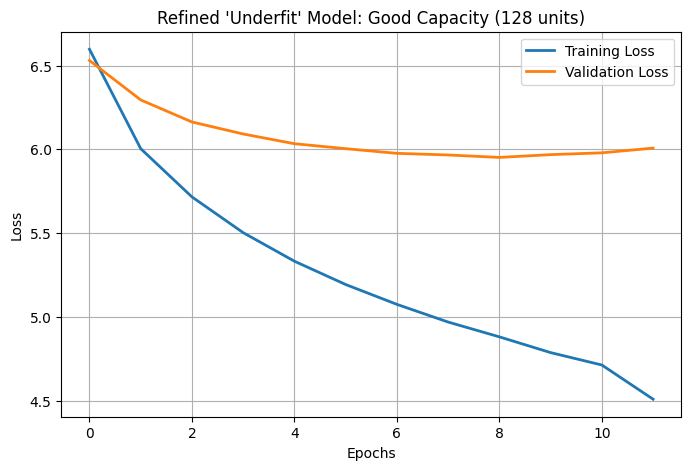

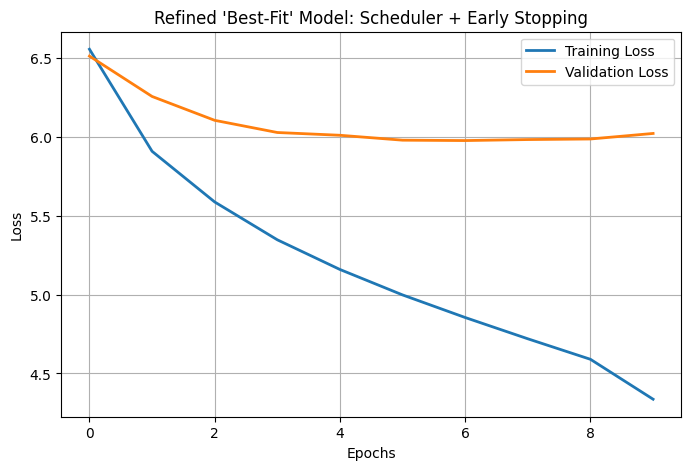

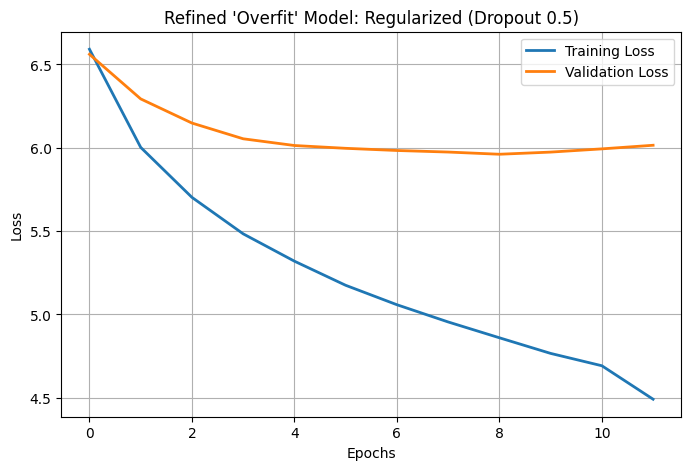

In [70]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses, title):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Training Loss", linewidth=2)
    plt.plot(val_losses, label="Validation Loss", linewidth=2)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# 1. Plot Refined 'Underfit' (Now a Good Capacity Model)
plot_losses(
    good_fit_train_losses,
    good_fit_val_losses,
    "Refined 'Underfit' Model: Good Capacity (128 units)"
)

# 2. Plot Refined 'Best-Fit' (With Scheduler)
plot_losses(
    best_train_losses,
    best_val_losses,
    "Refined 'Best-Fit' Model: Scheduler + Early Stopping"
)

# 3. Plot Refined 'Overfit' (Now Regularized)
plot_losses(
    reg_train_losses,
    reg_val_losses,
    "Refined 'Overfit' Model: Regularized (Dropout 0.5)"
)